In [1]:
# Questions
# Do we do HWE check on gangstr? check chr21:8993159
# Compute MI rate per locus, can filter on that?
# check low MI rate trios
# check sample whose trio we said was missing

In [2]:
%pylab inline

import pandas as pd
data = pd.read_csv("results/mend_chr21.tab", sep="\t", 
                   names=["chrom","pos","motif","sample","method","gbs","MI","gtscore"])

Populating the interactive namespace from numpy and matplotlib


[0.9411677283325262, 0.9466533236776561, 0.9490900659636328, 0.9512095073154774, 0.9542441534506719]
[0.9768616744298121, 0.9805136031710704, 0.9823781621002353, 0.9842083294178324, 0.9864225105441969]
[0.9878701238668367, 0.9895765876852928, 0.9907351045545689, 0.9914965832874462, 0.9924957372505038]
[0.9863433601612311, 0.9879911566676716, 0.9893580258103989, 0.9906756299824058, 0.9920587800872896]
[0.9749212350346566, 0.9777034478755514, 0.9790108155165036, 0.9808073377968595, 0.9830015162251328]
[0.9646268488201423, 0.9655833088451367, 0.9669114593837868, 0.9689753560550426, 0.9721224014227019]
[0.9438732981383717, 0.9548538152128234, 0.9645103621796994, 0.9740748632715391, 0.9822253000923361]


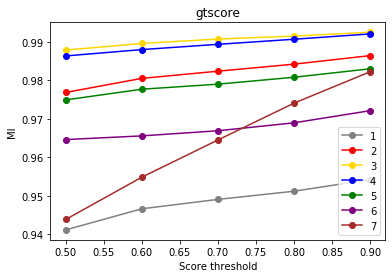

In [4]:
# MI vs. gtscore by period
percolors = ["gray","red","gold","blue","green","purple","brown"]

def PlotByScore(data, scorecol, percolors):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    for period in range(1, 8):
        if period < 7:
            pdata = data[data["motif"].apply(len)==period].copy()
        else: pdata = data[data["motif"].apply(len)>=period].copy()
        mis = []
        ns = []
        thresh = np.arange(0.5, 1.0, 0.1)
        for t in thresh:
            mis.append(np.mean(pdata[pdata[scorecol]>=t]["MI"]))
            ns.append(pdata[pdata[scorecol]>=t].shape[0])
        ax.plot(thresh, mis, marker="o", color=percolors[period-1], label=period)
        print(mis)
    ax.set_xlabel("Score threshold")
    ax.set_ylabel("MI")
    ax.set_title(scorecol)
    ax.legend(loc="lower right")
    
PlotByScore(data, "gtscore", percolors)

In [5]:
# by method (advntr|eh|hipstr|gangstr)
data.groupby(["method"], as_index=False).agg({"MI": np.mean, "sample": len}).sort_values(["MI"], ascending=False)

,method,MI,sample
5,0|1|1|0,0.990286,64343
6,0|1|1|1,0.987952,129480
3,0|1|0|0,0.983026,26983
4,0|1|0|1,0.982184,10440
10,1|1|0|1,0.976705,601
1,0|0|1|0,0.976560,1566877
7,1|0|0|0,0.942627,2109
2,0|0|1|1,0.938088,2492575
8,1|0|0|1,0.895623,1188
0,0|0|0|1,0.886871,449029


,sample,MI,pos
276,HG02683,0.926375,7674
293,HG02776,0.934737,7646
462,NA10843,0.935113,7567
152,HG01683,0.935889,7643
486,NA12739,0.936510,7513


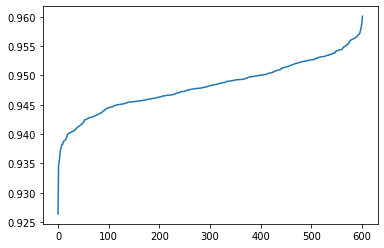

In [6]:
# by sample. check by ancestry
bysample = data.groupby("sample", as_index=False).agg({"MI": np.mean, "pos": len}).sort_values("MI")
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(range(bysample.shape[0]), bysample["MI"])
bysample.head()

In [12]:
# (advntr|eh|hipstr|gangstr)
bypos = data.groupby(["method","pos"], as_index=False).agg({"MI": np.mean, "sample": len, 'gtscore':np.mean})

In [22]:
# Bad gangstr-only calls
gangstr_only = bypos[(bypos["method"]=="0|0|0|1") & (bypos["sample"]>10)].sort_values(["MI","sample"])
gangstr_only

,method,pos,MI,sample,gtscore
1538,0|0|0|1,37677771,0.312253,253,0.186838
1847,0|0|0|1,41757999,0.342246,187,0.488663
1346,0|0|0|1,35806576,0.363636,11,0.292727
364,0|0|0|1,20460618,0.399351,308,0.531039
1537,0|0|0|1,37655180,0.408060,397,0.752695
...,...,...,...,...,...
326,0|0|0|1,19808112,1.000000,602,0.999252
671,0|0|0|1,25577031,1.000000,602,0.998355
1072,0|0|0|1,32134480,1.000000,602,0.989568
1129,0|0|0|1,32968745,1.000000,602,0.994784


Text(0, 0.5, 'Score')

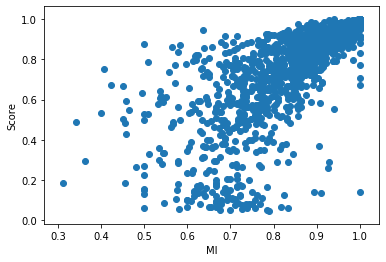

In [23]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(gangstr_only['MI'], gangstr_only['gtscore'])
ax.set_xlabel("MI")
ax.set_ylabel("Score")

In [19]:
# Bad advntr-only calls
bypos[(bypos["method"]=="1|0|0|0") & (bypos["sample"]>10)].sort_values(["MI","sample"])

,method,pos,MI,sample,gtscore
16321,1|0|0|0,31671897,0.585366,41,0.955854
16328,1|0|0|0,43719168,0.650794,63,0.931587
16320,1|0|0|0,30880126,0.880000,25,0.952800
16322,1|0|0|0,32393012,0.889241,316,0.887057
16325,1|0|0|0,42024343,0.902655,113,0.937168
16323,1|0|0|0,34614946,0.937500,16,1.000000
16324,1|0|0|0,41316674,0.945205,219,0.937854
16326,1|0|0|0,42311309,0.960168,477,0.965115
16327,1|0|0|0,42346245,1.000000,225,0.991778
16331,1|0|0|0,45504503,1.000000,602,1.000000
